# MAPIE - How to use MAPIE for your own model

In this tutorial we describe how to use custom MAPIE wrapper to use your own model with MAPIE via an example of intent classification with a LM BERT model from Transformers Hugging face package.

The use case we are dealing with here is as follows: a language model is used to detect the user's intent/command to automate an action (as might be expected of a personal assistant/home automation system).

The challenge is then to be certain of the user's action to avoid triggering unwanted actions. Indeed, if the language model is uncertain, we ask the user for clarification. The constraint is to solicit the user as little as possible to make the experience more fluid.

The model and dataset chosen do not come from a home automation system but do the job for the purposes of this tutorial.
***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import copy, deepcopy

import warnings
warnings.filterwarnings("ignore")

from utils.config import SMALL_FIGSIZE, MEDIUM_FIGSIZE, LARGE_FIGSIZE
sns.set_palette('tab20c')

np.random.seed(101)

### I) Obtain data and split it into train, calibration and validation datasets

In [31]:
from datasets import load_dataset
from utils.data.clinc import sample_and_split_dataset, get_dataframe, get_X_y
from utils.data.clinc import FEATURES, LABEL, TARGET, PREDICTION, SET, SET_LABEL


nb_train, nb_calib, nb_test = 1000, 1000, 10000

dataset = load_dataset("clinc/clinc_oos", 'plus')  # ['imbalanced', 'plus', 'small']
ds_train, ds_calib, ds_test = sample_and_split_dataset(dataset, nb_calib=nb_calib, nb_test=nb_test)
df_train, df_calib, df_test = get_dataframe(ds_train, ds_calib, ds_test)
(X_train, y_train), (X_calib, y_calib), (X_test, y_test) = get_X_y(df_train, df_calib, df_test)

### II) Obtain the LM BERT model

In [3]:
from transformers import pipeline
from utils.data.clinc import get_label_mapping

#pipe = pipeline("text-classification", model="seddiktrk/distilbert-base-uncased-finetuned-clinc", device=0)
#pipe = pipeline("text-classification", model="Serj/intent-classifier", device=0)
pipe = pipeline("text-classification", model="transformersbook/distilbert-base-uncased-finetuned-clinc", device=0)
idx2lab, lab2idx, label_list = get_label_mapping(ds_train)

In [4]:
from utils.data.clinc import dom2acts, act2dom, dom2idx, idx2dom, dom_list

### III) Show an inference with the LM BERT model

In [5]:
# Show some examples
X_instr = 'Could you send these metting details at 6pm?'
y_pred_instr = pipe(X_instr, top_k=2)
print(y_pred_instr)

[{'label': 'meeting_schedule', 'score': 0.10211676359176636}, {'label': 'make_call', 'score': 0.06421568989753723}]


***
## MAPIE: model training, calibration and prediction (MAPIE/scikit-learn routine)
### 0) Create you own MAPIE wrapper

The custom MAPIE wrapper is an intermediate class that implements the `fit`, `predict` and `predict_proba` methods with respect to the scikit-learn API.
- The `fit` method is used to train the model (here do nothing because the model is already trained),
- the `predict` method is used to make predictions
- and the `predict_proba` method is used to make predictions with uncertainty estimates.

This ensures that the model can be used with the MAPIE library by adapting the shape of the method's input and output.

```python
class MapieFromTransformers():
    def __init__(self, estimator, lab2idx, **kwargs) -> None:
        self.estimator = estimator
        self.lab2idx_ = lab2idx
        self.classes_ = list(self.lab2idx_.values())
    
    def fit(self, X, y):
        return self

    def predict_proba(self, X, **kwargs):
        # Adapt the shape of X with respect to the estimator API
        new_X = [x[0] for x in X]
    
        # Call the predict method of the estimator
        y_pred_raw = self.estimator(new_X, top_k=None)

        # Adapt the shape of y_pred_raw with respect to the mapie API
        key_fct = lambda elt: self.lab2idx_[elt['label']]
        sort_fct = lambda x: [elt['score'] for elt in sorted(x, key=key_fct)]
        y_proba = np.array(list(map(sort_fct, y_pred_raw)))

        # Return the prediction
        return y_proba

    def predict(self, X):
        y_pred = np.argmax(self.predict_proba(X), axis=1)
        return y_pred
````


### 1) Run the 4 steps of the MAPIE routine

The MAPIE routine is still composed of the same 4 steps:
1. Identify a (pre-trained) model (here our own model wrapped in our custom MAPIE wrapper).
2. Wrap it with the MAPIE class:
   - Choose the non-conformity score.
   - and compute conformity scores on calibration data.
3. Predict the target on the test data to obtain the prediction sets.

This routine is comparable to that of any scikit-learn-compatible estimator.

In [25]:
import numpy as np
from mapie.classification import MapieClassifier
from mapie.mondrian import MondrianCP
from mapie.conformity_scores import LACConformityScore, APSConformityScore
from utils.model import MapieFromTransformers


# 1) Get main predictor.
kwargs_predictor={'lab2idx': lab2idx}
clf = MapieFromTransformers(estimator=pipe, **kwargs_predictor)

# 2) Get the non-conformity score.
kwargs_score={}
csf = APSConformityScore(**kwargs_score)

# 3) Conformalize the main predictor (wrap with MAPIE conformal class).
kwargs_conformalizer={'conformity_score': csf, 'cv': 'prefit'}  # split conformal setting
mapie_classifier = MondrianCP(MapieClassifier(estimator=clf, **kwargs_conformalizer))
mapie_classifier = mapie_classifier.fit(
    X_calib, y_calib,
    partition=[dom2idx[act2dom[idx2lab[y]]] for y in clf.predict(X_calib)], #clf.predict(X_calib)
)

# 4) Obtain predictions and sets of predictions.
alpha = 0.2
alpha_list = np.array([alpha])
kwargs_predict = {'include_last_label': 'randomized'}
y_pred, y_pis = mapie_classifier.predict(
    X_test, alpha=alpha_list,
    partition=[dom2idx[act2dom[idx2lab[y]]] for y in clf.predict(X_test)],
    **kwargs_predict
)
y_proba = clf.predict_proba(X_test)

In [32]:
# 4) Obtain predictions and sets of predictions.
alpha = 0.2
alpha_list = np.array([alpha])
kwargs_predict = {'include_last_label': 'randomized'}
y_pred, y_pis = mapie_classifier.predict(
    X_test, alpha=alpha_list,
    partition=[dom2idx[act2dom[idx2lab[y]]] for y in clf.predict(X_test)],
    **kwargs_predict
)
y_proba = clf.predict_proba(X_test)

### 2) Visualise the results

Here we concatenate all the necessary results:
- the features (here the text to classify),
- the target (here the label to predict),
- the label (here the name of the label) to predict,
- the prediction (here the predicted label),
- the name of the predicted label,
- the probability of the true label,
- the probability of the predicted label,
- the prediction set size,
- if the example is well covered by the prediction set,

In [33]:
# See a picture of the predictions made by the LM BERT model
# Get all the results in a dataframe
pd_results = pd.DataFrame({
    FEATURES: df_test[FEATURES],
    TARGET: df_test[TARGET],
    LABEL: [idx2lab[y] for y in y_test],
    PREDICTION: y_pred,
    'pred_names': [idx2lab[y] for y in y_pred],
    'group_true': [act2dom[idx2lab[y]] for y in y_test],
    'group_pred': [act2dom[idx2lab[y]] for y in y_pred],
    'y_test_proba': np.take_along_axis(np.array(y_proba), np.array(y_test).reshape(-1, 1), axis=1)[:,0],
    'y_pred_proba': np.take_along_axis(np.array(y_proba), np.array(y_pred, dtype=int).reshape(-1, 1), axis=1)[:,0],
    'width': np.sum(y_pis[:,:,0], axis=-1),
    'covered': np.take_along_axis(np.array(y_pis[:,:,0]), np.array(y_test, dtype=int).reshape(-1, 1), axis=1)[:,0]
})
pd_results

,text,intent,intent_name,prediction,pred_names,group_true,group_pred,y_test_proba,y_pred_proba,width,covered
0,what is the carry-on policy for flights on luf...,62,carry_on,62.0,carry_on,travel,travel,0.759870,0.759870,0.0,0.0
1,i want to know how many vacation days i have used,148,pto_used,148.0,pto_used,work,work,0.481267,0.481267,2.0,1.0
2,are you okay,82,greeting,82.0,greeting,small_talk,small_talk,0.460537,0.460537,1.0,1.0
3,open meeting rooms from one to three pm,18,schedule_meeting,18.0,schedule_meeting,work,work,0.662860,0.662860,0.0,0.0
4,please put dusting on my list of things to do,65,todo_list_update,65.0,todo_list_update,home,home,0.421649,0.421649,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5344,i would like to know where i can find my w2 fo...,122,w2,122.0,w2,work,work,0.800762,0.800762,0.0,0.0
5345,talk faster,119,change_speed,119.0,change_speed,meta,meta,0.595367,0.595367,1.0,1.0
5346,send davis a text i'll be there in a few,26,text,26.0,text,utility,utility,0.711446,0.711446,1.0,1.0
5347,how much do i earn a year,93,income,93.0,income,work,work,0.589952,0.589952,1.0,1.0


### 3) Visualise the empirical distribution of non-conformity scores

First of all, we can obtain the non-conformity scores (in `mapie_classifier.conformity_scores_`) and then recover the quantiles associated with the different levels of risk.

In [34]:
# Round alpha to the closest value in the list
alpha_dict = {np.round(alpha, 2): i for i, alpha in enumerate(alpha_list)}
# Compute alpha correction (adjust alpha w.r.t quantile correction)
alpha_cor_list = 1-np.clip(np.ceil((1-alpha_list)*(nb_calib+1))/nb_calib, a_min=0, a_max=1)

# Select alpha, index and correction for the following plots
alpha = 0.2
alpha_idx = alpha_dict[alpha]
alpha_cor = alpha_cor_list[alpha_idx]

### 4) Visualise the empirical distribution of prediction sets sizes

Now, we propose to visualise the empirical distribution of prediction sets sizes

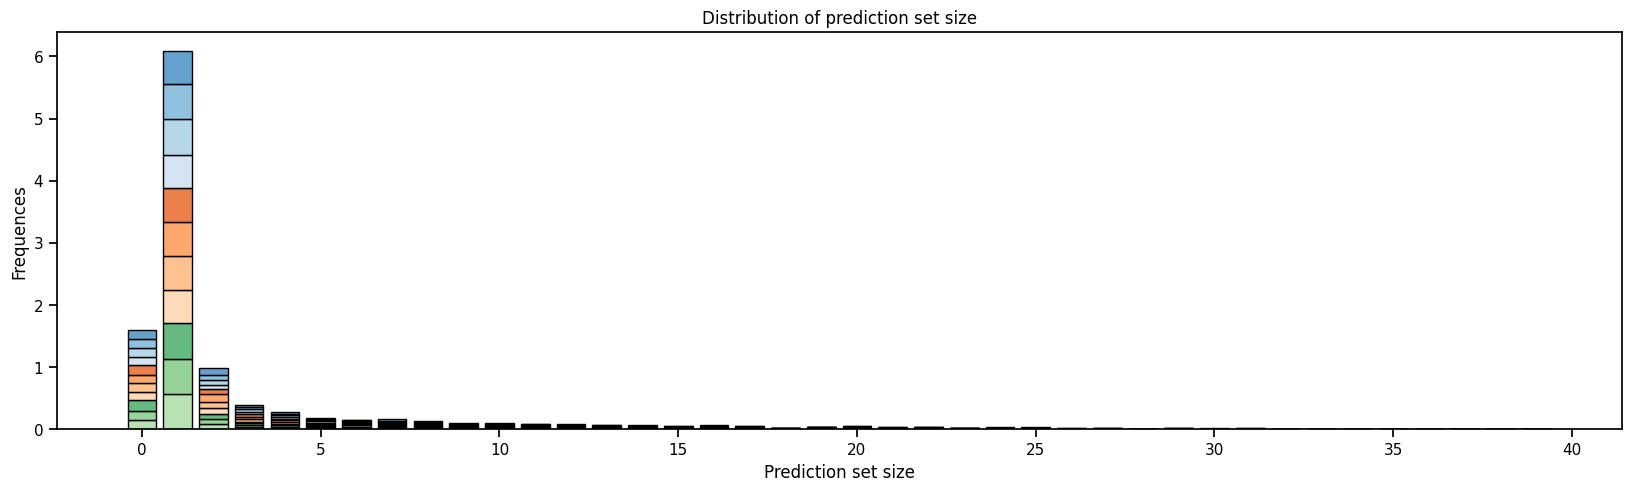

In [35]:
from utils.plot import plot_size_set_distribution

# Sort DataFrame by label names
pd_results = pd_results.sort_values(by=[LABEL])

# Get the size of the prediction sets for each test sample
size_sets = np.sum(y_pis[:,:,alpha_idx], axis=-1)
pd_results['size_set'] = size_sets

# Plot the empirical distribution of the size of the prediction sets
kwargs = {'discrete': True, 'multiple': 'stack', 'shrink': 0.8, 'legend': False}
plot_size_set_distribution(pd_results, label='LABEL', figsize=LARGE_FIGSIZE, hue='group_pred', **kwargs)

### 5) Visualize the coverage by group, do we see any disparities between groups?

We know that the marginal coverage is guaranted by the theoretical results. However, we can still check if the coverage is uniform across groups.

In [36]:
from sklearn.metrics import accuracy_score
from mapie.metrics import classification_coverage_score, classification_mean_width_score

coverage_ = []
accuracy_ = []
set_size_ = []
number_obs_ = []

idx_size_ = [idx for idx, item in enumerate(pd_results[LABEL])]
y_test_ = pd_results[TARGET][idx_size_]
y_preds_ = pd_results[PREDICTION][idx_size_]
y_pss_ = y_pis[idx_size_, :, 0]

number_obs_.append(len(idx_size_))
accuracy_.append(accuracy_score(y_test_, y_preds_))
coverage_.append(classification_coverage_score(y_test_, y_pss_))
set_size_.append(classification_mean_width_score(y_pss_))

# Compute metrics for each group (coverage, accuracy, number of observations)
#for label in np.sort(label_list):
for domain in dom_list:
    idx_size_ = [idx for idx, item in enumerate(pd_results['group_pred']) if item == domain]
    y_test_ = pd_results[TARGET][idx_size_]
    y_preds_ = pd_results[PREDICTION][idx_size_]
    y_pss_ = y_pis[idx_size_, :, 0]

    number_obs_.append(len(idx_size_))
    accuracy_.append(accuracy_score(y_test_, y_preds_))
    coverage_.append(classification_coverage_score(y_test_, y_pss_))
    set_size_.append(classification_mean_width_score(y_pss_))


0.7980931015143017


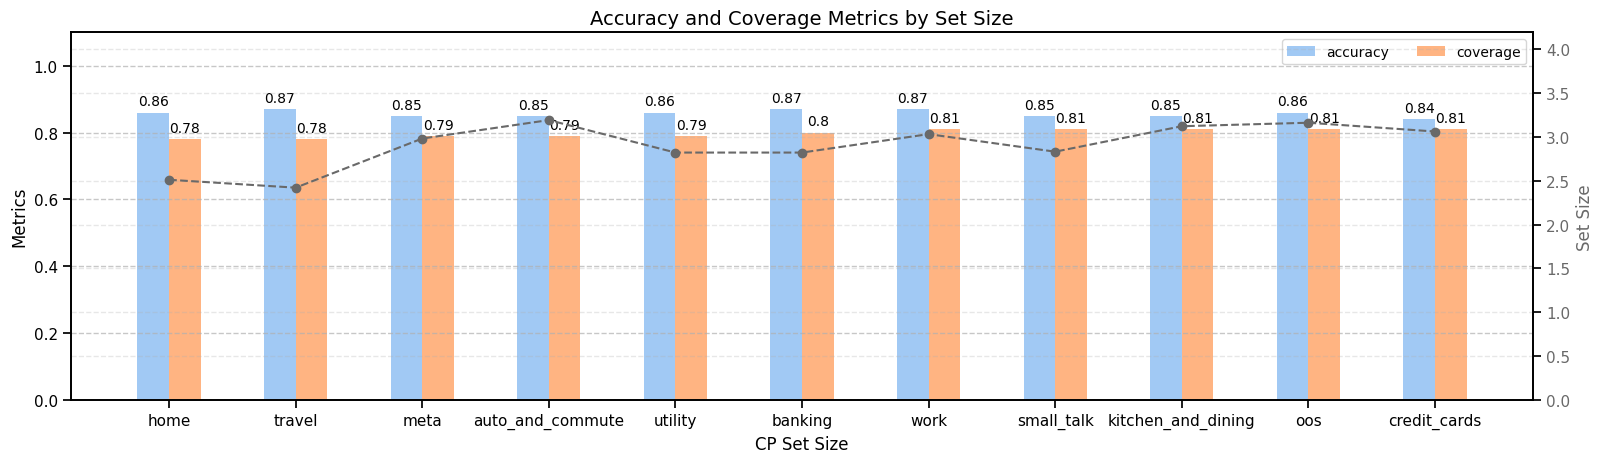

In [37]:
from utils.plot import plot_metrics_inside_groups

print(coverage_[0])

new_indexes = np.argsort(coverage_[1:])
metrics = {
    'accuracy': tuple(np.round(accuracy_[1:], 2)[new_indexes]),
    'coverage': tuple(np.round(coverage_[1:], 2)[new_indexes]),
    'set size': tuple(np.round(set_size_[1:], 2)[new_indexes]),
}

# Plot metrics for each group (coverage, accuracy, number of observations)
plot_metrics_inside_groups(metrics, np.array(dom_list)[new_indexes], number_obs_, figsize=LARGE_FIGSIZE)
#plt.hlines(coverage_[0], 0, len(label_list), linestyles='dashed', colors='red', label='marginal coverage')

We can see that some groups (almost half of the total) have less coverage than the target coverage. This is due to the fact that marginal coverage does not imply any constraint on coverage within groups.